In [2]:
"""
airline_satisfaction_modeling.py

Complete pipeline: ETL -> EDA -> two models (Logistic Regression, RandomForest) -> evaluate (log loss primary)
Requires:
    pip install pandas numpy scikit-learn matplotlib joblib
"""

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score, confusion_matrix, RocCurveDisplay
import joblib

In [3]:
# -------------------------
# Configuration / settings
# -------------------------
FILEPATH = r"C:\Users\Radejoro\RayPython\MARJANTA_DATA_CW3 (S).csv"   # change if needed
RANDOM_STATE = 42
TEST_SIZE = 0.20
VAL_SIZE = 0.10  # if you want a separate validation set (optional)
asset = "./results"

os.makedirs(asset, exist_ok=True)

In [8]:
# -------------------------
# 1) Read CSV safely
# -------------------------
def safe_read_csv(path):
    encodings = ['utf-8', 'latin-1', 'cp1252', 'utf-16']
    for enc in encodings:
        try:
            df = pd.read_csv(path, encoding=enc)
            print(f"Read using encoding: {enc}; shape={df.shape}")
            return df
        except Exception as e:
            print(f"Failed with {enc}: {e}")
    raise ValueError("Failed to read CSV with tried encodings.")

df = safe_read_csv(FILEPATH)


Failed with utf-8: 'utf-8' codec can't decode byte 0xe3 in position 1: invalid continuation byte
Read using encoding: latin-1; shape=(103904, 27)


In [9]:
# -------------------------
# 2) Quick inspection
# -------------------------
print("Columns:")
print(df.columns.tolist())
print("Missing values per column (top 10):")
print(df.isnull().sum().sort_values(ascending=False).head(20))

Columns:
['Ref', 'id', 'Gender', 'Satisfied', 'Age', 'Age Band', 'Type of Travel', 'Class', 'Flight Distance', 'Destination', 'Continent', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
Missing values per column (top 10):
Arrival Delay in Minutes             310
id                                     0
Ref                                    0
Satisfied                              0
Age                                    0
Age Band                               0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Destination                            0
Gender                                 0
Continent         

In [10]:
# -------------------------
# 3) ETL & feature selection
# -------------------------
# Drop ID-like columns if present
for c in ['Ref', 'id']:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

# Impute missing Arrival Delay in Minutes with median if present
if 'Arrival Delay in Minutes' in df.columns:
    df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].median())

# Map the target - ensure column exists
if 'Satisfied' not in df.columns:
    raise ValueError("Target column 'Satisfied' not found in dataset.")

df['Satisfied_bin'] = df['Satisfied'].map({'Y':1, 'N':0})
# Drop rows where mapping failed (if any)
df = df.dropna(subset=['Satisfied_bin'])

# Split X, y
X = df.drop(columns=['Satisfied','Satisfied_bin'])
y = df['Satisfied_bin'].astype(int)

# Identify numeric and categorical features (simple heuristic)
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)


Numeric cols: ['Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
Categorical cols: ['Gender', 'Age Band', 'Type of Travel', 'Class', 'Destination', 'Continent']


In [11]:
# -------------------------
# 4) Train/test split (stratified)
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

# Optionally derive a validation set from train (not required)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=VAL_SIZE/(1-TEST_SIZE), stratify=y_train, random_state=RANDOM_STATE)


In [12]:
# 5) Preprocessing & Pipelines
# -------------------------
# Standard scaling for numerical; OneHot for categoricals
num_transform = StandardScaler()
cat_transform = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transform, num_cols),
    ('cat', cat_transform, cat_cols)
], remainder='drop')

pipe_logistic = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

pipe_rf = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1))
])


In [13]:
# -------------------------
# 6) Fit models
# -------------------------
print("Fitting Logistic Regression...")
pipe_logistic.fit(X_train, y_train)

print("Fitting Random Forest...")
pipe_rf.fit(X_train, y_train)


Fitting Logistic Regression...
Fitting Random Forest...


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Flight Distance',
                                                   'Inflight wifi service',
                                                   'Departure/Arrival time '
                                                   'convenient',
                                                   'Ease of Online booking',
                                                   'Gate location',
                                                   'Food and drink',
                                                   'Online boarding',
                                                   'Seat comfort',
                                                   'Inflight entertainment',
                                                   'On-board service',
                                                   'Leg room service',
                                                   'Baggage handling',
                                                   'Checkin service',
                                                   'Inflight service',
                                                   'Cleanliness',
                                                   'Departure Delay in Minutes',
                                                   'Arrival Delay in Minutes']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender', 'Age Band',
                                                   'Type of Travel', 'Class',
                                                   'Destination',
                                                   'Continent'])])),
                ('clf',
                 RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                        random_state=42))])

In [14]:
# -------------------------
# 7) Predict & Evaluate (test set)
# -------------------------
def evaluate_model(pipe, X_t, y_t, model_name="model"):
    y_pred = pipe.predict(X_t)
    if hasattr(pipe, "predict_proba"):
        y_proba = pipe.predict_proba(X_t)[:,1]
    else:
        # fallback
        y_proba = pipe.predict(X_t).astype(float)
    acc = accuracy_score(y_t, y_pred)
    rocauc = roc_auc_score(y_t, y_proba)
    lloss = log_loss(y_t, y_proba)
    cm = confusion_matrix(y_t, y_pred)
    return {'accuracy': acc, 'roc_auc': rocauc, 'log_loss': lloss, 'confusion_matrix': cm, 'y_proba': y_proba, 'y_pred': y_pred}

res_log = evaluate_model(pipe_logistic, X_test, y_test, "LogisticRegression")
res_rf  = evaluate_model(pipe_rf, X_test, y_test, "RandomForest")

# Print metrics
print("\n=== Logistic Regression ===")
print(f"Accuracy: {res_log['accuracy']:.4f}")
print(f"ROC-AUC:  {res_log['roc_auc']:.4f}")
print(f"Log Loss: {res_log['log_loss']:.4f}")
print("Confusion matrix:\n", res_log['confusion_matrix'])

print("\n=== Random Forest ===")
print(f"Accuracy: {res_rf['accuracy']:.4f}")
print(f"ROC-AUC:  {res_rf['roc_auc']:.4f}")
print(f"Log Loss: {res_rf['log_loss']:.4f}")
print("Confusion matrix:\n", res_rf['confusion_matrix'])

# Save metrics to a CSV for record
metrics_df = pd.DataFrame({
    'model': ['LogisticRegression','RandomForest'],
    'accuracy':[res_log['accuracy'], res_rf['accuracy']],
    'roc_auc':[res_log['roc_auc'], res_rf['roc_auc']],
    'log_loss':[res_log['log_loss'], res_rf['log_loss']]
})
metrics_df.to_csv(os.path.join(asset,'model_metrics.csv'), index=False)



=== Logistic Regression ===
Accuracy: 0.9219
ROC-AUC:  0.9619
Log Loss: 0.1917
Confusion matrix:
 [[ 2902   895]
 [  728 16256]]

=== Random Forest ===
Accuracy: 0.9858
ROC-AUC:  0.9958
Log Loss: 0.0737
Confusion matrix:
 [[ 3611   186]
 [  109 16875]]


<Figure size 640x480 with 0 Axes>

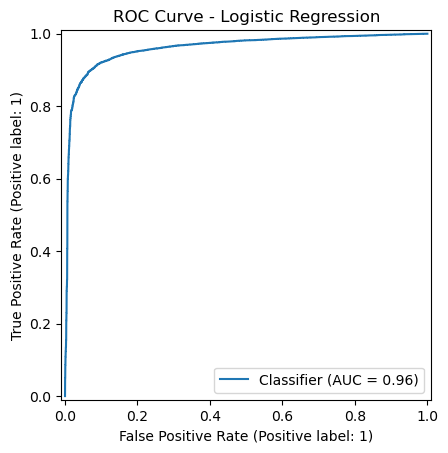

<Figure size 640x480 with 0 Axes>

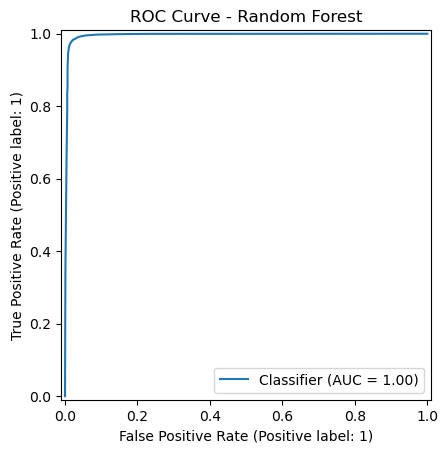

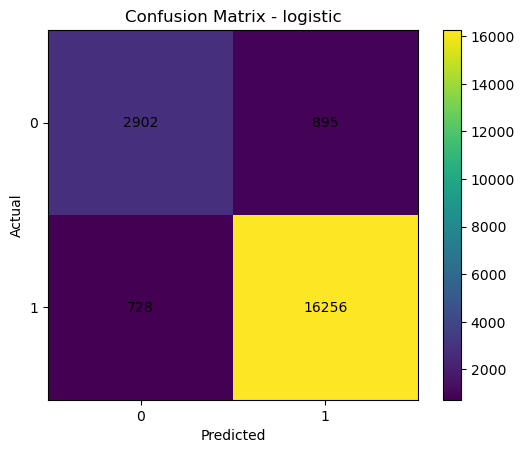

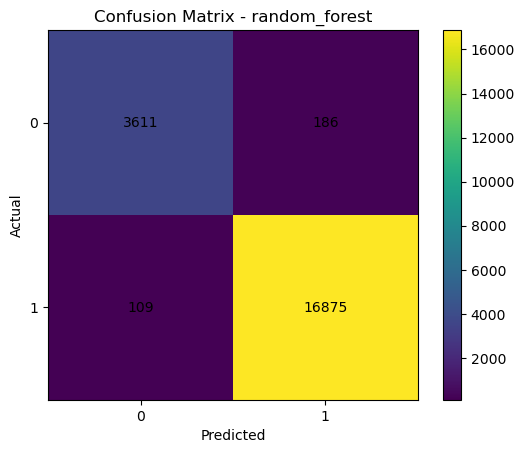

In [15]:
# -------------------------
# 8) Plots: ROC curves and confusion matrices
# -------------------------
plt.figure()
RocCurveDisplay.from_predictions(y_test, res_log['y_proba'])
plt.title("ROC Curve - Logistic Regression")
plt.savefig(os.path.join(asset,'roc_logistic.png'))
plt.show()

plt.figure()
RocCurveDisplay.from_predictions(y_test, res_rf['y_proba'])
plt.title("ROC Curve - Random Forest")
plt.savefig(os.path.join(asset,'roc_random_forest.png'))
plt.show()

# Confusion matrices (simple heatmap-like display using imshow)
for name, res in [('logistic', res_log), ('random_forest', res_rf)]:
    cm = res['confusion_matrix']
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'Confusion Matrix - {name}')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0,1])
    plt.yticks([0,1])
    for (i, j), val in np.ndenumerate(cm):
        plt.text(j, i, int(val), ha='center', va='center')
    plt.savefig(os.path.join(asset,f'confusion_{name}.png'))
    plt.show()


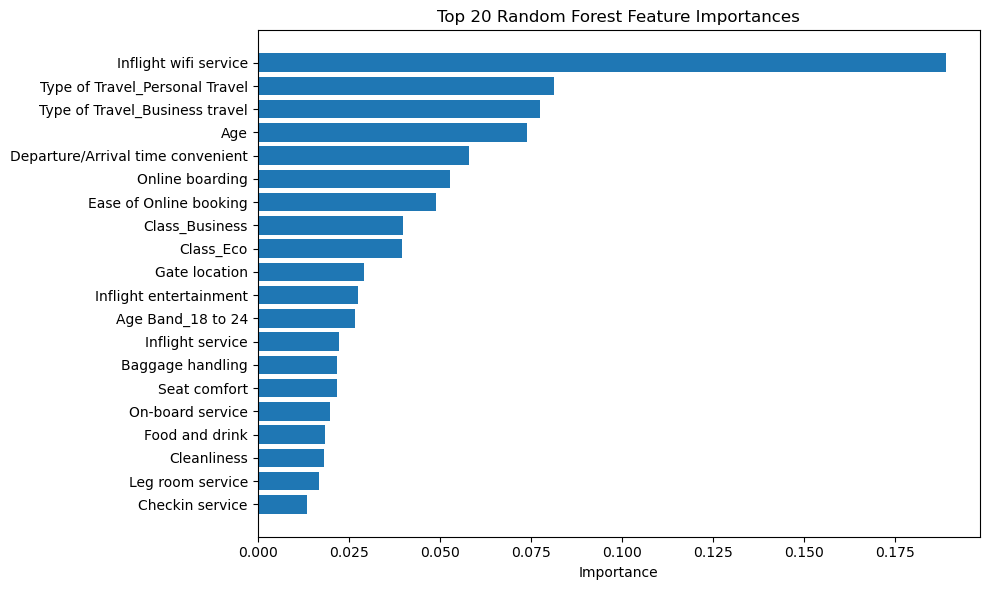

In [17]:
# -------------------------
# 9) Feature importance (Random Forest) - approximate mapping to original names
# -------------------------
# Need to get transformed feature names
ohe = pipe_rf.named_steps['pre'].named_transformers_['cat']
# safe handling if OHE exists:
cat_feature_names = []
if hasattr(ohe, 'get_feature_names_out'):
    cat_feature_names = list(ohe.get_feature_names_out(cat_cols))
else:
    # older sklearn support:
    try:
        cat_feature_names = list(ohe.get_feature_names(cat_cols))
    except Exception:
        cat_feature_names = [f"{c}_?" for c in cat_cols]

feature_names = list(num_cols) + cat_feature_names

rf_clf = pipe_rf.named_steps['clf']
if hasattr(rf_clf, 'feature_importances_'):
    importances = rf_clf.feature_importances_
    fi = pd.DataFrame({'feature': feature_names, 'importance': importances})
    fi = fi.sort_values('importance', ascending=False).head(30)
    fi.to_csv(os.path.join(asset,'rf_top_feature_importances.csv'), index=False)

    # Barplot (top 20)
    plt.figure(figsize=(10,6))
    plt.barh(fi['feature'].iloc[:20][::-1], fi['importance'].iloc[:20][::-1])
    plt.title('Top 20 Random Forest Feature Importances')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.savefig(os.path.join(asset,'rf_feature_importances.png'))
    plt.show()
else:
    print("RandomForest does not expose feature importances.")


In [19]:
# -------------------------
# 10) Save models (optional)
# -------------------------
joblib.dump(pipe_logistic, os.path.join(asset,'pipeline_logistic.joblib'))
joblib.dump(pipe_rf, os.path.join(asset,'pipeline_random_forest.joblib'))

print("All outputs saved to:", asset)

All outputs saved to: ./results
